# Importando Bibliotecas

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sys
sys.path.insert(1, '../Arquivos_Auxiliares')
import Funcoes_auxiliares as f

# Funções Auxiliares

# Importando Dados

In [4]:
past = '../Resultados/tabelas/Previsoes/'

In [5]:
previsoes_np = {}
previsoes = []
for index in range(60):
    with open(past+f'Prev_pro/Previsao_pro{index}.txt', "r") as arquivo:
	    previsoes.append([float(demanda) for demanda in arquivo.read().split(',')])
            
previsoes_np['demandas'] = previsoes
previsoes_np = pd.DataFrame(previsoes_np)
previsoes_np.head()


,demandas
0,"[89.54337310791016, 89.25847625732422, 90.0580..."
1,"[89.42227172851562, 89.07727813720703, 89.8582..."
2,"[89.5674057006836, 89.30921173095703, 90.11029..."
3,"[89.55894470214844, 89.2660140991211, 90.06253..."
4,"[89.55184936523438, 89.26032257080078, 90.0593..."


In [6]:
len(previsoes_np.iloc[1,0])

17

In [7]:
previsoes_sar = {}
previsoes = []
for index in range(60):
    with open(past+f'Prev_sar/Previsao_sar{index}.txt', "r") as arquivo:
	    previsoes.append([float(demanda) for demanda in arquivo.read().split(',')])
            
previsoes_sar['demandas'] = previsoes
previsoes_sar = pd.DataFrame(previsoes_sar)

In [8]:
df_demandas = pd.read_csv('../Resultados/tabelas/Demandas_treinamento/demandas')[['date','demandas']]
df_demandas['date'] = pd.to_datetime(df_demandas['date'], format='%Y-%m-%d')

In [9]:
with open('../Resultados/tabelas/Prev_teste/test_sarima.txt', "r") as arquivo:
	test_sar = [float(demanda) for demanda in arquivo.read().split(',')]

with open('../Resultados/tabelas/Prev_teste/test_pro.txt', "r") as arquivo:
	test_np = [float(demanda) for demanda in arquivo.read().split(',')]


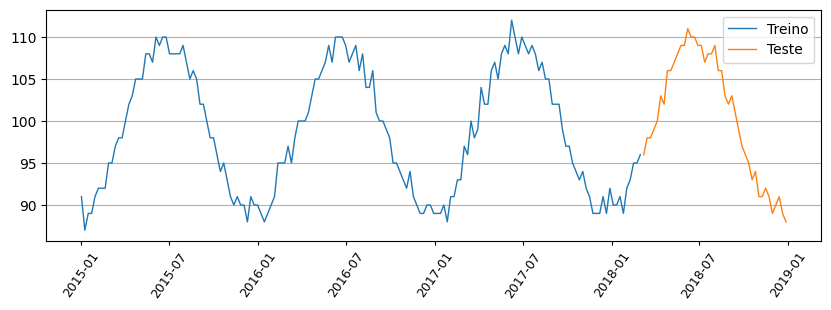

In [10]:
df_train, df_test =df_demandas.iloc[:166],df_demandas.iloc[166:]

fig=plt.figure(figsize=(10,3))

ax=fig.add_subplot(1,1,1)
plt.plot(df_train.date,df_train.demandas,label='Treino', linewidth=1)
plt.plot(df_test.date,df_test.demandas,label='Teste', linewidth=1)
#plt.xticks([df_demandas.iloc[i,1] for i in [0,53,105,157,166,204]])
plt.tick_params(axis='x', labelsize=9, length=3)
plt.legend()
plt.grid(axis='y')
for tick in ax.get_xticklabels():
    tick.set_rotation(55)

#plt.savefig('C:/Users/marcio/Documents/Prev_For_ULS/Resultados/img/DemandasTreinoTeste.png', bbox_inches='tight',pad_inches = 0.1,format='png')

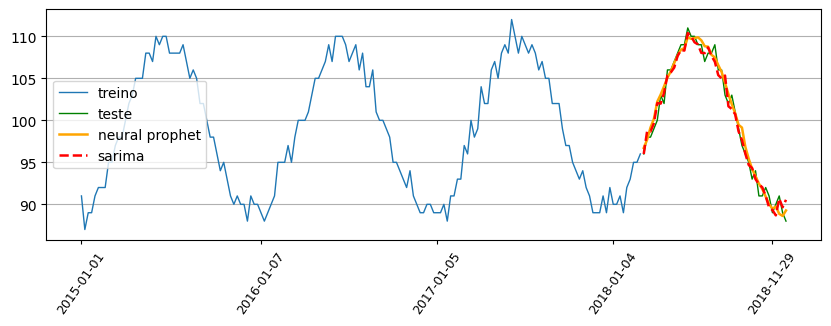

In [11]:
fig=plt.figure(figsize=(10,3))
ax=fig.add_subplot(1,1,1)

plt.plot(df_demandas.date.iloc[:166],df_demandas.demandas.iloc[:166],label='treino', linewidth=1)
plt.plot(df_demandas.date.iloc[166:],df_demandas.demandas.iloc[166:],label='teste', linewidth=1,color='green')

plt.plot(df_demandas.date.iloc[166:],test_np,label='neural prophet', linewidth=1.8,color='orange')
plt.plot(df_demandas.date.iloc[166:],test_sar,label='sarima', linestyle='--',linewidth=1.8,color='red')
plt.xticks([df_demandas.date.values[i] for i in [0,53,105,157,204]])
plt.tick_params(axis='x', labelsize=9, length=3)
for tick in ax.get_xticklabels():
    tick.set_rotation(55)
plt.grid(axis='y')
plt.legend()


#plt.savefig('C:/Users/marcio/Documents/Prev_For_ULS/Resultados/img/prev_testes.png', bbox_inches='tight',pad_inches = 0.1,format='png')


# Analise Das Previsões

In [12]:
ic_np = pd.read_csv('../Resultados/tabelas/Intervalos_Confianca/NP/IC_NP0')
ic_sa = pd.read_csv('../Resultados/tabelas/Intervalos_Confianca/SA/IC_SA0')

In [13]:
previsao_demanda_np = f.describe_var(previsoes_np,'demandas')
previsao_demanda_sar = f.describe_var(previsoes_sar,'demandas')

In [14]:
boxPlot_previsao_np = f.dataFrame_to_boxPlot(previsao_demanda_np,'demandas')
boxPlot_previsao_sar = f.dataFrame_to_boxPlot(previsao_demanda_sar,'demandas')

In [15]:
import datetime
init_date = '2018-12-27'
init_date = datetime.datetime.strptime(init_date, '%Y-%m-%d')
K=18

dates = [init_date + datetime.timedelta(weeks=i) for i in range(1,K)]
dates = [date.strftime('%Y-%m-%d') for date in dates]
column_date = [date for date in dates for j in range(60)]

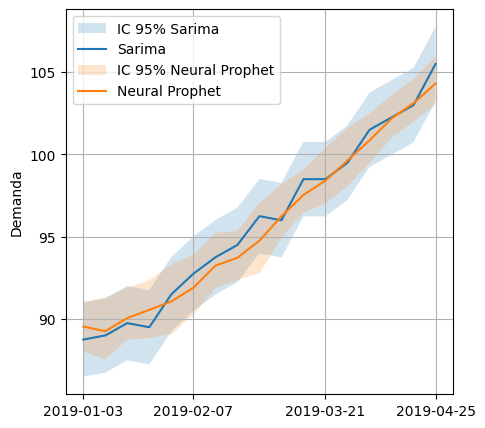

In [17]:
fig=plt.figure(figsize=(5,5))
plt.fill_between(dates, ic_sa['upper demandas'], ic_sa['lower demandas'],
                alpha=0.2, interpolate=True,label='IC 95% Sarima')
plt.plot(dates,previsoes_sar['demandas'].iloc[0],label='Sarima')
plt.fill_between(dates, ic_np['yhat1 2.5%'], ic_np['yhat1 97.5%'],
                alpha=0.2, interpolate=True,label='IC 95% Neural Prophet')
plt.plot(dates,previsoes_np['demandas'].iloc[0],label='Neural Prophet')
plt.xticks([0,5,11,16])
#plt.scatter(boxPlot_demandas['x'],boxPlot_demandas['demandas'],marker='x',color='red',label='Demandas Históricas')
plt.grid(axis='both')
plt.ylabel('Demanda')
plt.legend()
plt.savefig('../Resultados/img/IC.png', format='png', bbox_inches='tight',pad_inches = 0.1)

c:\Users\Marcio Barros\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Marcio Barros\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Marcio Barros\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Marcio Barros\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarni

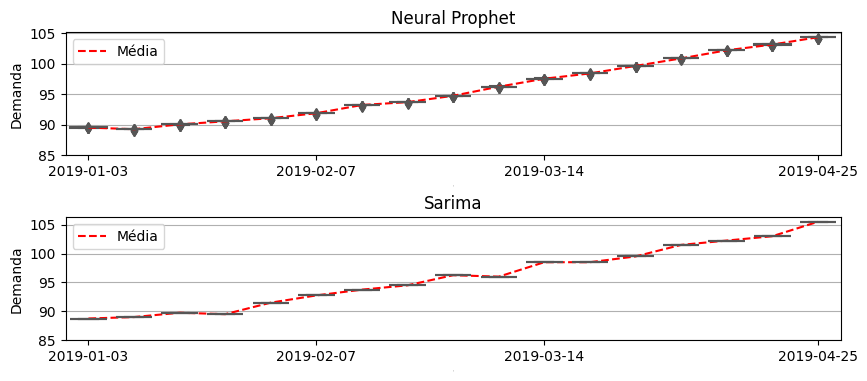

In [39]:
fig=plt.figure(figsize=(10,4))
#fig.suptitle('Distribuição das Previsões de Demandas por Período')



plt.subplots_adjust(wspace=0, hspace=0.5)

ax=fig.add_subplot(2,1,1)
ax.set_title('Neural Prophet')
sns.boxplot(data=boxPlot_previsao_np,x='x',y='demandas',color='turquoise')
plt.plot(previsao_demanda_np.columns,previsao_demanda_np.describe().iloc[1,:],color='red',linestyle='--',label='Média')
plt.grid(axis='y')
plt.xlabel([], fontsize=0)

plt.xticks([0,5,10,16])
plt.yticks([85,90,95,100,105])
plt.ylabel('Demanda')
plt.legend()


ax=fig.add_subplot(2,1,2)
ax.set_title('Sarima')
sns.boxplot(data=boxPlot_previsao_sar,x='x',y='demandas',color='turquoise')
plt.plot(previsao_demanda_np.columns,previsao_demanda_sar.describe().iloc[1,:],color='red',linestyle='--',label='Média')
plt.grid(axis='y')
plt.xlabel([], fontsize=0)
plt.xticks([0,5,10,16])
plt.yticks([85,90,95,100,105])
plt.ylabel('Demanda')
plt.legend()

#plt.savefig('C:/Users/marcio/Documents/Codigos/Prev_For_ULS/Resultados/img/Previsoes.png', format='png', bbox_inches='tight',pad_inches = 0.1)